In [1]:
import os
import re
import time
import math
import json

import numpy as np
import pandas as pd
import seaborn as sns

from tqdm import tqdm

from PIL import Image

import matplotlib.pyplot as plt

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, datasets, utils
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler

In [2]:
root_path = "/home/becode/Projects/Bagaar/images/"

In [3]:
facial_dataset = datasets.ImageFolder(
    root = os.path.join(root_path, "train"),
    transform = transforms.Compose([
        transforms.Grayscale(),transforms.ToTensor()
    ]) 
)

emotion_lookup = {idx: emotion for emotion, idx in facial_dataset.class_to_idx.items()}
idx_to_emotion = lambda f: emotion_lookup[f]

In [4]:
train_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=32)

In [5]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([32, 1, 48, 48])

In [170]:
class CustomDataSet(Dataset):
    def __init__(self, root, transform=transforms.ToTensor()):
        self.ROOT = root
        self.transform = transform
        self.images = sorted(os.listdir(os.path.join(root)))
        self.labels = [0 for i in range(len(self.images))]
        
    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = Image.open(os.path.join(self.ROOT, self.images[idx]))
        #img = plt.imread(os.path.join(self.ROOT, self.images[idx]))
        if self.transform: img = self.transform(img)
        label = self.labels[idx]

        return img, label

In [235]:
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.CenterCrop(210),
    transforms.Resize((48, 48)),
    transforms.ToTensor()
])
apple_loader = CustomDataSet("images/apple", transform=transform)

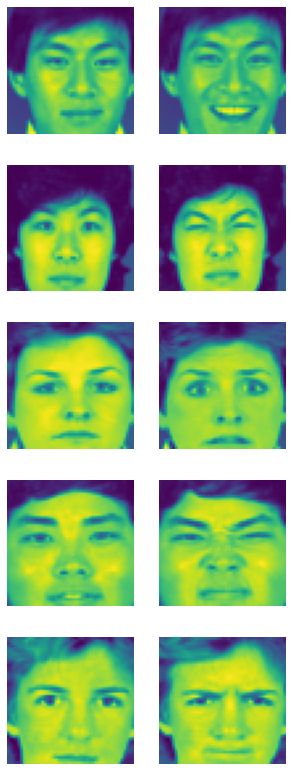

In [236]:
fig, ax = plt.subplots(5,2, figsize=(5,14))
ax = ax.flatten()
for i, (img, _) in enumerate(apple_loader):
    ax[i].set_axis_off()
    ax[i].imshow(img[0])

In [5]:
class EmotionClassifier(nn.Module):
    def __init__(self):
        super(EmotionClassifier, self).__init__()
        
        self.block1 = self.conv_block(c_in=1, c_out=256, dropout=0.1, kernel_size=5, stride=1, padding=2)
        self.block2 = self.conv_block(c_in=256, c_out=128, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.block3 = self.conv_block(c_in=128, c_out=64, dropout=0.1, kernel_size=3, stride=1, padding=1)
        self.lastcnn = nn.Conv2d(in_channels=64, out_channels=7, kernel_size=12, stride=1, padding=0)
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        
    def forward(self, x):
        x = self.block1(x)
        #print("block1", x.shape)
        #fig, ax = plt.subplots(8,8,figsize=(10,10))
        #numpy = torch.detach(x).numpy()
        #for axis in ax.flatten():
        #    axis.set_axis_off()
        #    axis.imshow(numpy[0][np.random.randint(x.shape[1])])
        #plt.show()
        
        x = self.maxpool(x)
        #print("maxpool", x.shape)
        #fig, ax = plt.subplots(8,8,figsize=(10,10))
        #numpy = torch.detach(x).numpy()
        #for axis in ax.flatten():
        #    axis.set_axis_off()
        #    axis.imshow(numpy[0][np.random.randint(x.shape[1])])
        #plt.show()
        
        x = self.block2(x)
        #print("block2", x.shape)
        #fig, ax = plt.subplots(8,8,figsize=(10,10))
        #numpy = torch.detach(x).numpy()
        #for axis in ax.flatten():
        #    axis.set_axis_off()
        #    axis.imshow(numpy[0][np.random.randint(x.shape[1])])
        #plt.show()
        
        x = self.block3(x)
        #print("block3", x.shape)
        #fig, ax = plt.subplots(8,8,figsize=(10,10))
        #numpy = torch.detach(x).numpy()
        #for axis in ax.flatten():
        #    axis.set_axis_off()
        #    axis.imshow(numpy[0][np.random.randint(x.shape[1])])
        #plt.show()
        
        x = self.maxpool(x)
        #print("maxpool", x.shape)
        #fig, ax = plt.subplots(8,8,figsize=(10,10))
        #numpy = torch.detach(x).numpy()
        #for axis in ax.flatten():
        #    axis.set_axis_off()
        #    axis.imshow(numpy[0][np.random.randint(x.shape[1])])
        #plt.show()
        
        x = self.lastcnn(x)
        
        return x
    
    def conv_block(self, c_in, c_out, dropout,  **kwargs):
        seq_block = nn.Sequential(
            nn.Conv2d(in_channels=c_in, out_channels=c_out, **kwargs),
            nn.BatchNorm2d(num_features=c_out),
            nn.ReLU(),
            nn.Dropout2d(p=dropout)
        )
        
        return seq_block

In [6]:
def class_acc(y_pred, y_test):
    y_pred_tag = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_tags = torch.max(y_pred_tag, dim = 1)
    correct_results_sum = (y_pred_tags == y_test).sum().float()
    
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    return acc

In [88]:
device = torch.device("cpu")
model = EmotionClassifier()
model.to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

EmotionClassifier(
  (block1): Sequential(
    (0): Conv2d(1, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block2): Sequential(
    (0): Conv2d(256, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (block3): Sequential(
    (0): Conv2d(128, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.1, inplace=False)
  )
  (lastcnn): Conv2d(64, 7, kernel_size=(12, 12), stride=(1, 1))
  (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [ ]:
batch_size = 256
n_classes = 7
train_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=batch_size)

acc_history, loss_history = [],[]

for epoch in range(500, 1000):
    model.train()
    
    for i, (X, y) in enumerate(train_loader):
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        
    y_train_pred = model(X).squeeze()
    predict = y_train_pred.max(1)[1]

    train_acc = class_acc(y_train_pred, y)
    acc_history.append(int(train_acc))

    train_loss = criterion(y_train_pred, y)
    train_loss.backward()
    loss_history.append(float(train_loss))

    optimizer.step()
    
    torch.save(model.state_dict(), f"models/classifier_{epoch+0:03}.torch")
    
    print(f"Epoch{epoch+0:03} | acc: {train_acc}% | loss: {train_loss}")
    predict_count = dict(zip(*np.unique(predict, return_counts=True)))
    print("Predict:", predict_count)
    target_count = dict(zip(*np.unique(y, return_counts=True)))
    print("Target :", target_count)
    print("STD:", np.std(list(predict_count.values())))
    if max(predict_count.values()) < batch_size /(n_classes-2):
        print("Even distribution")
    print("\n")

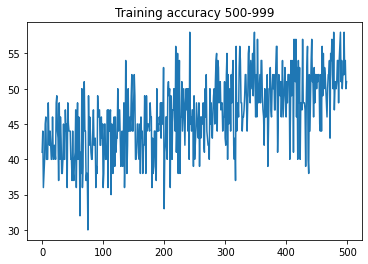

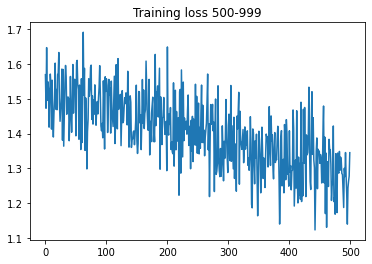

In [95]:
plt.plot(acc_history); plt.title("Training accuracy 500-999"); plt.show()
plt.plot(loss_history); plt.title("Training loss 500-999"); plt.show()

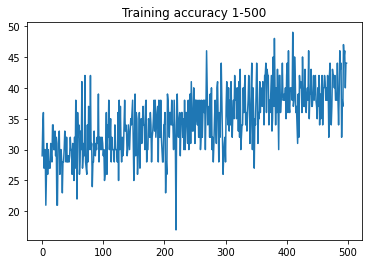

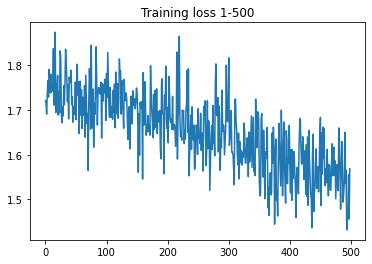

In [93]:
plt.plot(acc_history); plt.title("Training accuracy 1-500"); plt.show()
plt.plot(loss_history); plt.title("Training loss 1-500"); plt.show()

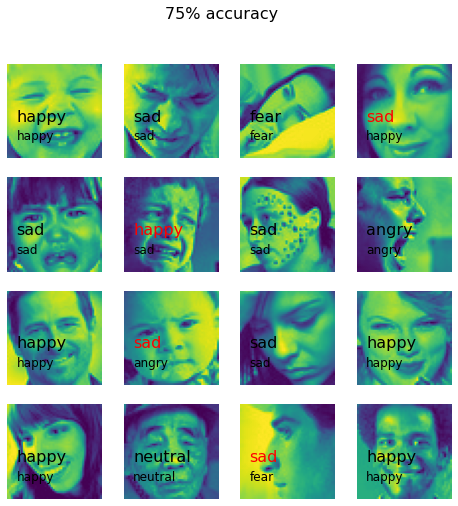

In [157]:
test_loader = DataLoader(dataset=facial_dataset, shuffle=True, batch_size=16)
single_batch = next(iter(train_loader))
single_batch[0].shape

model = EmotionClassifier()
model.load_state_dict(torch.load("models/classifier_995.torch"))
model.eval()

img, label = next(iter(test_loader))
predict = model(img).squeeze().max(1)[1]

fig, ax = plt.subplots(4,4, figsize=(8,8))
fig.suptitle(f"{int((label==predict).sum()/len(label)*100)}% accuracy", fontsize=16)
for i, axis in enumerate(ax.flatten()):
    axis.set_axis_off()
    axis.imshow(img[i][0])
    axis.text(.1,.2, fontsize=12, transform=axis.transAxes,
              s=emotion_lookup[int(label[i])])
    axis.text(.1,.4, fontsize=16, transform=axis.transAxes,
              s=emotion_lookup[int(predict[i])],
              c="k" if label[i]==predict[i] else "r")

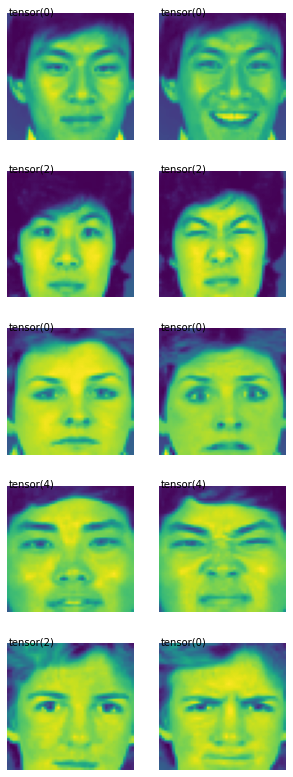

In [234]:
model = EmotionClassifier()
model.load_state_dict(torch.load("models/classifier_995.torch"))
model.eval()

fig, ax = plt.subplots(5,2, figsize=(5,14))
ax = ax.flatten()
for i, (img, _) in enumerate(apple_loader):
    img = img.reshape(-1, *img.shape)
    predict = model(img).squeeze().max(-1)[1]
    ax[i].set_axis_off()
    ax[i].imshow(img[0][0])
    ax[i].text(0,0,s=predict)